In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [3]:
from torchvision import datasets, transforms
data_path = './data/'
mnist_train = datasets.MNIST(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]))

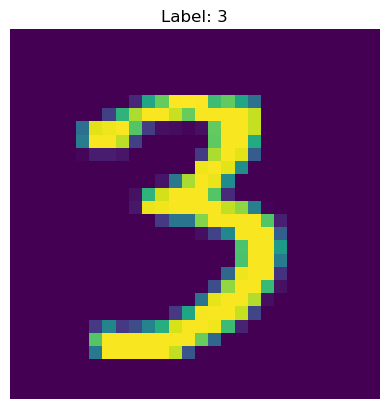

(tensor(0.1424), tensor(0.3216), tensor(0.), tensor(1.))

In [4]:
import matplotlib.pyplot as plt

# Select a random image from the dataset
index = 10000
image, label = mnist_train[index]

# Plot the image
plt.imshow(image.squeeze())
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()
image.mean(), image.std(), image.min(), image.max()


In [5]:
imgs = torch.stack([img for img, _ in mnist_train], dim = 3)

In [6]:
mean = imgs.view(1,-1).mean(dim=1).item()
std = imgs.view(1,-1).std().item()
mean, std

(0.13066047430038452, 0.30810782313346863)

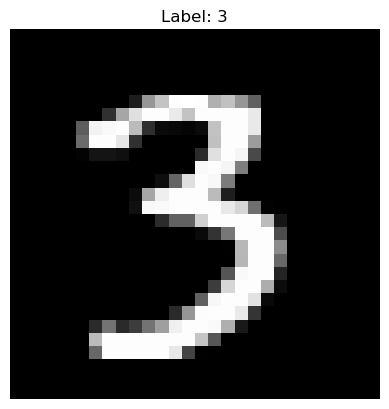

Minimum value: -0.42407387495040894
Maximum value: 2.8215432167053223
Mean of normalized images: 3.720237984339292e-08
Standard deviation of normalized images: 0.9999999403953552


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

mnist_train_normalized = datasets.MNIST(
    data_path, train=True, download=True,
    transform=transform
)

imgs_train_normalized = torch.stack([img for img, _ in mnist_train_normalized], dim = 3)

index = 10000
image2, label2 = mnist_train_normalized[index]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Label: {label2}')
plt.axis('off')
plt.show()
min_value = torch.min(imgs_train_normalized)
max_value = torch.max(imgs_train_normalized)
mean_normalized = imgs_train_normalized.view(1, -1).mean(dim=1).item()
std_normalized = imgs_train_normalized.view(1, -1).std().item()
print("Minimum value:", min_value.item())
print("Maximum value:", max_value.item())
print("Mean of normalized images:", mean_normalized)
print("Standard deviation of normalized images:", std_normalized)



In [8]:
mnist_val_normalized = datasets.MNIST(
    data_path, train=False, download=True,
    transform=transform
)

In [9]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 7 * 7, 32)  # Adjusted input size
        self.fc2 = nn.Linear(32, 10)  # Adjusted output size
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 7 * 7)  # Adjusted input size
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model = Net()
model(image2.unsqueeze(0))



tensor([[ 0.2051, -0.0413,  0.0378, -0.1080, -0.0290, -0.0849, -0.0929,  0.0601,
         -0.3156, -0.0425]], grad_fn=<AddmmBackward0>)

In [10]:
import datetime
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    param_dict = {}
    steps = 0
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            param_dict[steps] = [x.cpu().detach().numpy().copy() for x in list(model.parameters())]
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            steps += 1
        
        print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))
    return param_dict

Training on device cuda.


In [11]:
train_loader = torch.utils.data.DataLoader(mnist_train_normalized, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

params = training_loop(
    n_epochs = 5,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2024-02-26 13:39:48.709735 Epoch 1, Training loss 1.2481250492875764
2024-02-26 13:40:01.744094 Epoch 2, Training loss 0.49871688911210754
2024-02-26 13:40:15.600390 Epoch 3, Training loss 0.35449717597348857
2024-02-26 13:40:28.505947 Epoch 4, Training loss 0.27917099649559207
2024-02-26 13:40:41.910959 Epoch 5, Training loss 0.22756301165262519


In [12]:
train_loader = torch.utils.data.DataLoader(mnist_train_normalized, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(mnist_val_normalized, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.5f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

validate(model, train_loader, val_loader)
numel_list = [p.numel() for p in model.parameters()]
for p in model.parameters():
    print(p.shape)

Accuracy train: 0.94297
Accuracy val: 0.94230
torch.Size([16, 1, 3, 3])
torch.Size([16])
torch.Size([8, 16, 3, 3])
torch.Size([8])
torch.Size([32, 392])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [13]:
def translate_layer_params(layer_params_array):
    #this function will return a dictionary where the key will be the index of the parameter and the value will be the parameter itself, having in mind some arrays will be 2 dimetional
    translated_params = {}
    for i in range(layer_params_array.shape[0]):
        if len(layer_params_array.shape) == 1:
            translated_params[i] = layer_params_array[i]
        elif len(layer_params_array.shape) == 2:
            for j in range(layer_params_array[i].shape[0]):
                translated_params[(i,j)] = layer_params_array[i][j]
        else:
            layer_params_array = layer_params_array.reshape(layer_params_array.shape[0], -1)
            for j in range(layer_params_array[i].shape[0]):
                translated_params[(i,j)] = layer_params_array[i][j]
    return translated_params

def translate_params_epoch(params_epoch):
    all_translated_layers = []
    for layer in params_epoch:
        all_translated_layers.append(translate_layer_params(layer))
    return all_translated_layers

def translate_params(params_dict):
    all_translated_epochs = []
    for epoch in params_dict:
        all_translated_epochs.append(translate_params_epoch(params_dict[epoch]))
    return all_translated_epochs


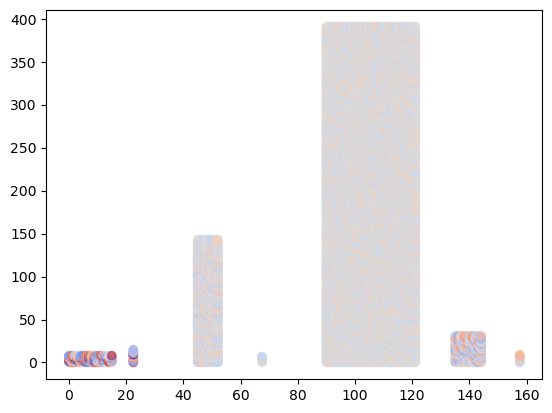

In [14]:
def plot_epoch_wave(all_epochs, epoch):
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for layer in range(len(all_epochs[epoch])):
        plt.plot(all_epochs[epoch][layer].values(), label=f'Layer {layer}', color=colors[layer % len(colors)])  # Use the colors

def plot_epoch_design(all_epochs, epoch):
    x_positions = []
    y_positions = []
    weights = []
    offset = 0
    space = (max([len(layer) for layer in all_epochs[epoch]]))**0.33
    for layer in all_epochs[epoch]:
        keys = list(layer.keys())
        values = list(layer.values())
        if type(keys[0]) == int:
            for i in range(len(keys)):
                x_positions.append(offset)
                y_positions.append(i)
                weights.append(values[i].item())
            offset += space
        else:
            for i in range(len(keys)):
                x_positions.append(keys[i][0] + offset)
                y_positions.append(keys[i][1])
                weights.append(values[i].item())
            offset += space
    
    plt.scatter(x_positions, y_positions,c = weights, cmap = 'coolwarm', alpha = 0.6)

plot_epoch_design(translate_params(params), 1)

        


50


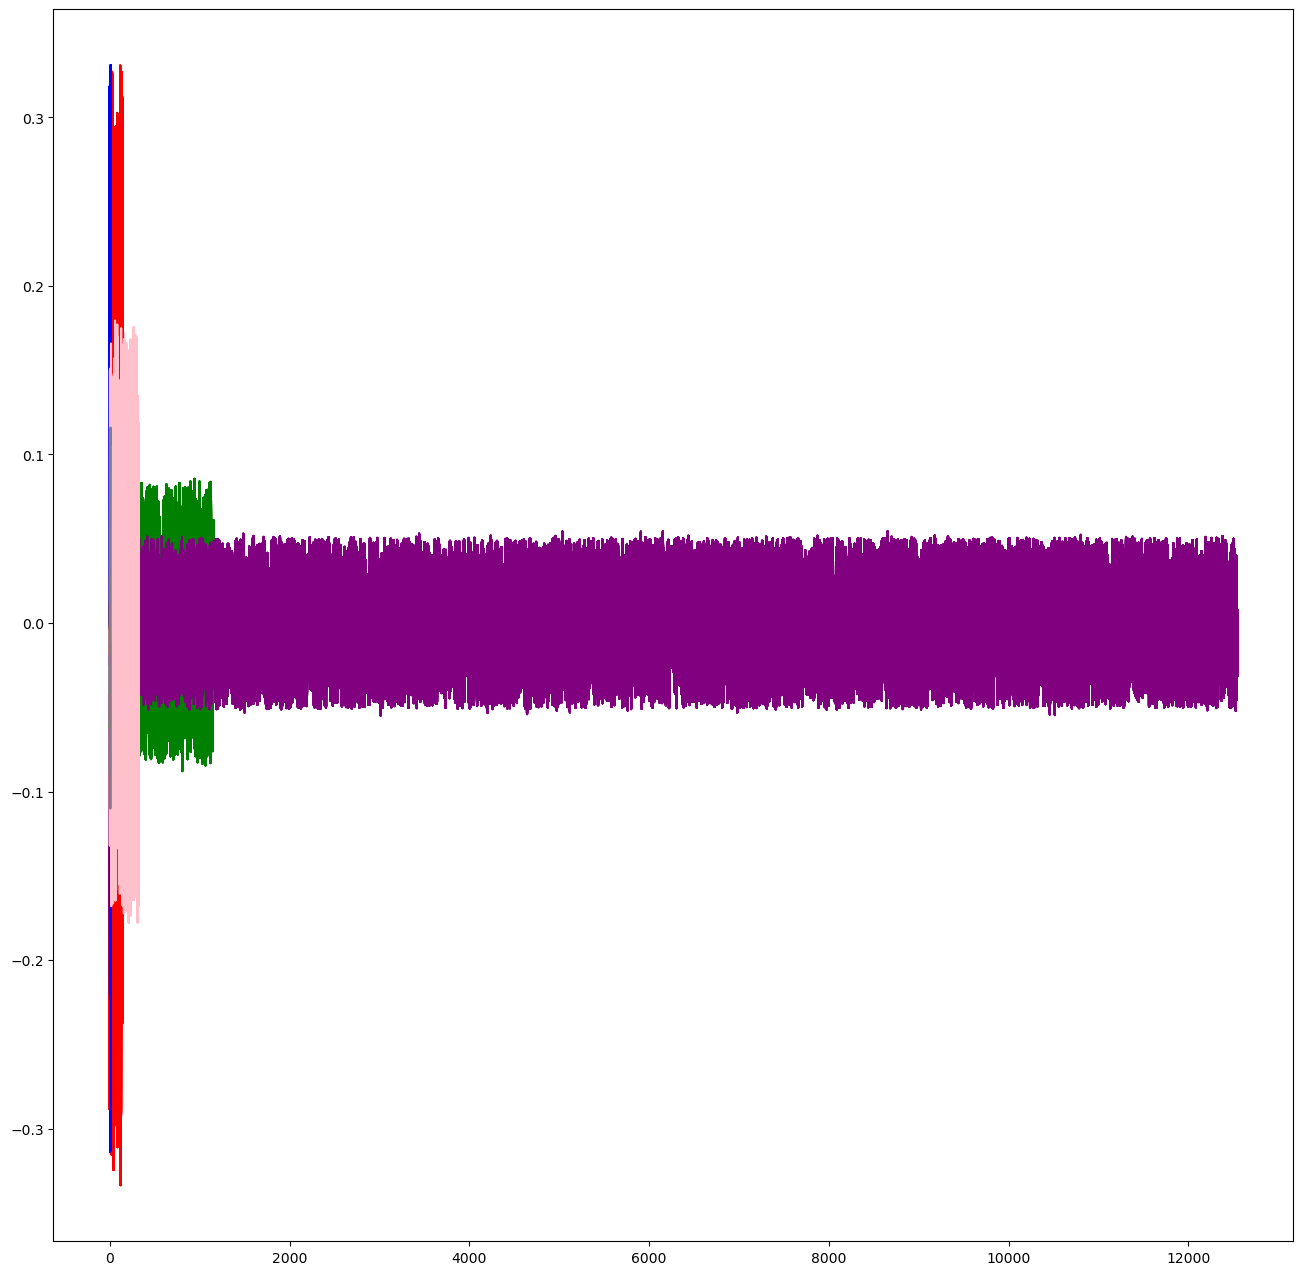

In [16]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
import os
gif_path = "test.gif"
plots = []
plt.figure(figsize=(16, 16))
translated = translate_params(params)[:50]
print(len(translated))
for x in range(len(translated)):
    plot_epoch_wave(translated, x)
    plt.savefig(f"{x}.jpg")
    plots.append(f"{x}.jpg")

frames = np.stack([iio.imread(f"{x}.jpg") for x in range(len(translated))], axis=0)

iio.imwrite(gif_path, frames)

for plot in plots:
    os.remove(plot)




